In [1]:
import gcsfs
import os.path as op

In [2]:
fs = gcsfs.GCSFileSystem(project='learning-2-learn-221016')

In [3]:
metadata_file = '2017_5_04_raw.json'
if not op.exists(metadata_file):
    fs.get(op.join('learning2learn/Buffalo/NWB-experiments/', metadata_file), metadata_file)

In [4]:
import json
from hdf5zarr import NWBZARRHDF5IO, HDF5Zarr

# import metadata from a json file
with open(metadata_file, 'r') as mfile:
    store = json.load(mfile)

f = fs.open('learning2learn/Buffalo/NWB-experiments/2017_5_04_raw.nwb', 'rb')

hdf5_zarr = HDF5Zarr(f, store = store, store_mode = 'r')
zgroup = hdf5_zarr.zgroup
io = NWBZARRHDF5IO(mode='r', file=zgroup, load_namespaces=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/hdmf/spec/namespace.py:470: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/srv/conda/envs/notebook/lib/python3.7/site-packages/hdmf/spec/namespace.py:470: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


In [5]:
print(zgroup.tree())

/
 ├── acquisition
 │   └── ElectricalSeries
 │       ├── data (275057279, 124) int16
 │       ├── electrodes (124,) int64
 │       └── starting_time () float64
 ├── analysis
 ├── file_create_date (1,) object
 ├── general
 │   ├── devices
 │   │   └── Device
 │   ├── experimenter (1,) object
 │   ├── extracellular_ephys
 │   │   ├── ElectrodeGroup
 │   │   │   └── device
 │   │   │       └── .link
 │   │   └── electrodes
 │   │       ├── filtering (124,) object
 │   │       ├── group (124,) uint64
 │   │       ├── group_name (124,) object
 │   │       ├── id (124,) int64
 │   │       ├── imp (124,) float64
 │   │       ├── label (124,) object
 │   │       ├── location (124,) object
 │   │       ├── x (124,) float64
 │   │       ├── y (124,) float64
 │   │       └── z (124,) float64
 │   ├── institution () object
 │   ├── keywords (3,) object
 │   ├── lab () object
 │   ├── notes () object
 │   └── source_script () object
 ├── identifier () object
 ├── processing
 ├── session_descriptio

In [6]:
data = zgroup['acquisition/ElectricalSeries/data']

In [7]:
import matplotlib.pyplot as plt

In [8]:
import dask.array as da

In [9]:
arr = da.from_zarr(data)

In [10]:
arr.shape

(275057279, 124)

In [11]:
arr = arr.T

In [12]:
arr.shape

(124, 275057279)

In [13]:
import ipywidgets as widgets

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
chan = widgets.SelectMultiple(
    options=np.arange(arr.shape[0]),
    value=[0],
    description='Channels:',
    disabled=False
    
)

time = widgets.IntSlider(
    value=0,
    min=0,
    max=arr.shape[-1]-5000,
    step=1,
    description='Starting timepoint:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

time_d = widgets.IntSlider(
    value=5000,
    min=0,
    max=10000,
    step=1,
    description='Window duration',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)



def f(time, time_d=5000, chan=[0]):
    fig, ax = plt.subplots()
    for c in chan:
        if c < 124:
            ax.plot(arr[c, time:time+time_d], label=f"Channel {c}")
    ax.legend()
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Voltage")
    plt.show()

out = widgets.interactive_output(f, {'chan': chan, 'time': time, 'time_d': time_d})

widgets.HBox([widgets.VBox([chan, time, time_d]), out])

In [20]:
from tools import init_cluster, batch_process

In [21]:
cluster, client = init_cluster()

In [22]:
cluster

In [32]:
arr = arr[None]

In [33]:
arr.shape

(1, 124, 275057279)

In [34]:
arr.persist()

,Array,Chunk
Bytes,68.21 GB,537.22 kB
Shape,"(1, 124, 275057279)","(1, 1, 268611)"
Count,126976 Tasks,126976 Chunks
Type,int16,numpy.ndarray


In [39]:
from mne.time_frequency import tfr_array_morlet

In [40]:
from functools import partial

In [119]:
freqs = np.logspace(10, 100, 10)

In [120]:
freqs

array([1.e+010, 1.e+020, 1.e+030, 1.e+040, 1.e+050, 1.e+060, 1.e+070,
       1.e+080, 1.e+090, 1.e+100])

In [121]:
my_morlet = partial(tfr_array_morlet, sfreq=40000, freqs=freqs)

In [122]:
foo = arr[:, 0, :1000000].compute()

In [123]:
foo = foo[None]

In [124]:
foo.shape

(1, 1, 1000000)

In [125]:
result = my_morlet(foo)

In [126]:
result.dtype

dtype('complex128')

In [127]:
result.shape

(1, 1, 10, 1000000)

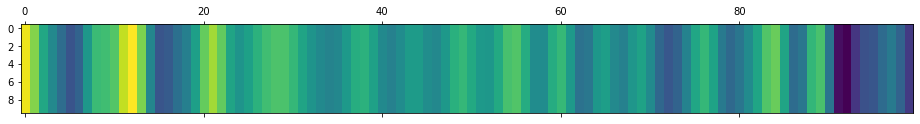

In [128]:
plt.matshow(np.abs(result[0, 0, :, :100]))

In [129]:
morlet_arr = arr.map_blocks(my_morlet, dtype=result.dtype, new_axis=2s)

In [130]:
morlet_arr

,Array,Chunk
Bytes,545.71 GB,4.30 MB
Shape,"(1, 124, 1, 275057279)","(1, 1, 1, 268611)"
Count,507905 Tasks,126976 Chunks
Type,complex128,numpy.ndarray


In [133]:
result.shape

(10, 2000)

In [138]:
np.abs(morlet_arr[0, 0, :, 0:5000].compute())

array([[39715.35947212, 38815.91964645, 37609.59547775, ...,
        27034.10645832, 27002.99375995, 27294.3217538 ],
       [39715.35947212, 38815.91964645, 37609.59547775, ...,
        27034.10645832, 27002.99375995, 27294.3217538 ],
       [39715.35947212, 38815.91964645, 37609.59547775, ...,
        27034.10645832, 27002.99375995, 27294.3217538 ],
       ...,
       [39715.35947212, 38815.91964645, 37609.59547775, ...,
        27034.10645832, 27002.99375995, 27294.3217538 ],
       [39715.35947212, 38815.91964645, 37609.59547775, ...,
        27034.10645832, 27002.99375995, 27294.3217538 ],
       [39715.35947212, 38815.91964645, 37609.59547775, ...,
        27034.10645832, 27002.99375995, 27294.3217538 ]])

In [141]:
arr.shape

(1, 124, 275057279)

In [143]:
chan = widgets.Select(
    options=np.arange(arr.shape[1]),
    value=[0],
    description='Channel:',
    disabled=False
    
)

time = widgets.IntSlider(
    value=0,
    min=0,
    max=arr.shape[-1]-500,
    step=1,
    description='Starting timepoint:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

time_d = widgets.IntSlider(
    value=50,
    min=0,
    max=1000,
    step=1,
    description='Window duration',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)



def f(time, time_d=5000, chan=0):
    fig, ax = plt.subplots()
    result = np.abs(morlet_arr[0, chan, :, time:time+time_d].compute())
    ax.matshow(result)
    ax.legend()
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Frequency (10Hz bins)")
    plt.show()s

out = widgets.interactive_output(f, {'chan': chan, 'time': time, 'time_d': time_d})

widgets.HBox([widgets.VBox([chan, time, time_d]), out])